In this part, we want to check and compare our model's performance on a dataset of images that have been mapped to the wrong labels. Ideally, the pre-trained should perform better than the randomly initialised model as it has been intensively trained on a larger dataset with the correct labels. The existing parameters that have been learned through the previous parts should help in preventing the reduction of the pre-trained model's performance quickly.

In [1]:
# importing the neccessary libraries
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for data augmentation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

In [2]:
# checking the number of images
root_dir = '../input/dataset3/mnistTask'
total_images = 0
for folder in sorted(os.listdir(root_dir)):    
    print(len(os.listdir(root_dir+'/'+folder)))
    total_images+=len(os.listdir(root_dir+'/'+folder))
    
print("Total number of images:",total_images)

5980
5807
6009
6037
5914
6139
6037
5954
6129
5994
Total number of images: 60000


(28, 28)


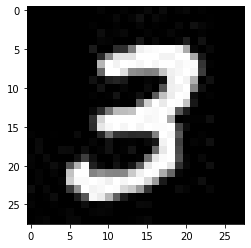

In [3]:
# plotting an random image.
img = plt.imread('../input/dataset3/mnistTask/0/image_000007.jpg')
print(img.shape)
plt.imshow(img,cmap='gray')
plt.show()

# Preprocessing

In [4]:
# creating lists for storing images and labels
X = [] #list for storing image arrays
y = [] # list for storing the image labels

Just like in part1, we are accessing the images from folders and assigning them labels. The major difference is that images in this dataset have been kept in the wrong folder.

In [5]:
# storing digits from 0 to 9 first
label = 0 # count will be used to store the respective label
for i in sorted(os.listdir(root_dir)): 
    for j in os.listdir(root_dir + "/" + i): # accessing the folder
        X.append(cv2.imread(root_dir+"/" + i + "/" + j)) # accessing images in the respective folder
        y.append(label)

    label+=1 #incrementing the count/label 
    if(label==10): break # if all the images from 0 to 9 have been stored then break out of the loop

In [6]:
# sanity check
print(len(X))
print(len(y))

60000
60000


Since we have to use the pre-trained model, we have to pad the images and increase their size and channels from 28x28x1 to 40x40x3 so that we don't face any problem while passing the images into the pre-trained model. The process is similar to what I've done in part 2.

In [7]:
# function to pad the images with 6 rows of black pixels on all 4 sides of the images using the PIL library
# Taken from: https://www.geeksforgeeks.org/add-padding-to-the-image-with-python-pillow/

def pad_black(img):
    img = Image.fromarray(img) # converting the pixel array to image
    width, height = img.size 

    # mentioning size of padding for all the four sides
    right = 6
    left = 6
    top = 6
    bottom = 6

    new_width = width + right + left
    new_height = height + top + bottom

    # pasting the padded sides on the image
    result = Image.new(img.mode, (new_width, new_height), (0, 0, 0))
    result.paste(img, (left, top))
    
    # converting the image back to a numpy array
    new_np = np.array(result)    
    return new_np

(28, 28, 3)
(40, 40, 3)


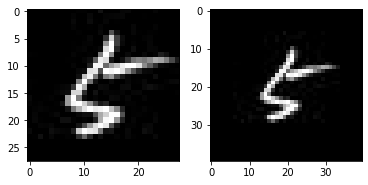

In [8]:
# picking a random image and applying the padding function to compare
plt.subplot(1,2,1)
plt.imshow(X[0])
print(X[0].shape)

plt.subplot(1,2,2)
plt.imshow(pad_black(X[0]))
print(pad_black(X[0]).shape)

plt.show()

In [9]:
# padding all the images
for i in range(len(X)):
    X[i]= pad_black(X[i])

In [10]:
# changing the data-type from list to a numpy array
X = np.array(X)
y = np.array(y)

In [11]:
# sanity check
print(X.shape)
print(y.shape)

(60000, 40, 40, 3)
(60000,)


In [12]:
# splitting the data into training and test set. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 10000)

# checking the shape of data and label
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 40, 40, 3)
(50000,)
(10000, 40, 40, 3)
(10000,)


In [13]:
# Normalizing the input for faster convergence
X_train = X_train.astype('float32')
X_train/=255

X_test = X_test.astype('float32')
X_test/=255

In [14]:
# converting labels to one-hot vectors
from  keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test= np_utils.to_categorical(y_test)

In [15]:
# sanity check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 40, 40, 3)
(50000, 10)
(10000, 40, 40, 3)
(10000, 10)


## Model building

In [16]:
# loading the model trained on MNIST dataset in part 2
from tensorflow.keras.models import load_model
part2_model = load_model('../input/part2-model/part2_model')
part2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 36, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         1

The model building and training is quite straightforward as the dimensions of input images in part 2 and part 3. We just have to initiliaze the pre-trained and train the model.

In [17]:
# initializing with the pre-trained model
model = part2_model

In [18]:
# To avoid the stagnatation of the model at the local minima we use ReduceLROnPlateau.
# It dynamically changes learning rate.
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# compiling the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# checkpoint
checkpoint_filepath = '/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
                                            filepath=checkpoint_filepath,
                                            save_weights_only=False,
                                            monitor='accuracy',
                                            mode='max',
                                            save_best_only=True
                                            )

# training the model
hist = model.fit(X_train, y_train,batch_size=32, epochs=100, callbacks=[reduce_lr],validation_data = (X_test,y_test))

Epoch 1/100
1563/1563 [==============================] - 11s 5ms/step - loss: 2.8659 - accuracy: 0.0902 - val_loss: 2.2623 - val_accuracy: 0.1139
Epoch 2/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.2533 - accuracy: 0.1122 - val_loss: 2.2261 - val_accuracy: 0.1071
Epoch 3/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.2233 - accuracy: 0.1134 - val_loss: 2.2188 - val_accuracy: 0.1071
Epoch 4/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.2176 - accuracy: 0.1127 - val_loss: 2.2190 - val_accuracy: 0.1047
Epoch 5/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.2168 - accuracy: 0.1139 - val_loss: 2.2149 - val_accuracy: 0.1101
Epoch 6/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.2147 - accuracy: 0.1184 - val_loss: 2.2182 - val_accuracy: 0.1105
Epoch 7/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.2137 - accuracy: 0.1142 - val_loss: 2.2162 - val_a

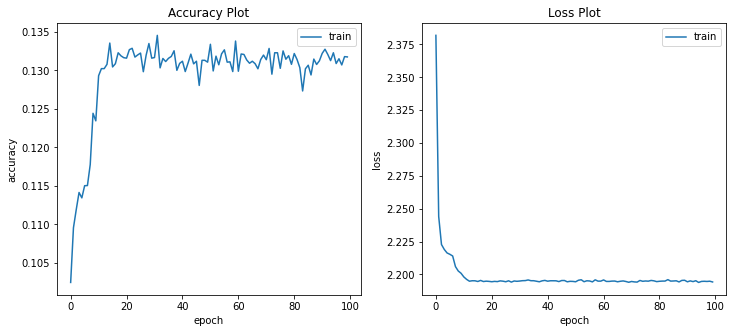

In [19]:
plt.figure(figsize = (12, 5))
# plotting the loss and accuracy of the model.

# plotting the accuracy vs epochs 
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.title("Accuracy Plot")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'])

# plotting the loss vs epochs
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.title("Loss Plot")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])

plt.show()

In [20]:
# Evaluating the performance of the pre-trained model on the current dataset
score = model.evaluate(X_test, y_test)
print("Testing loss : ", score[0])
print("Testing accuracy : ", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 2.2156 - accuracy: 0.1097
Testing loss :  2.2156362533569336
Testing accuracy :  0.10970000177621841


## Randomly initialized model

Training the images on a randomly initialized model. 
To make the random model comparable to the pre-trained model I have used the similar architecture. 
The only difference is that the convoltion layers in the previous models have been initialised with the pre-trained weights whereas the random model will be initiliazed with random parameters at the start.

In [21]:
# initializing the model 
random_model = Sequential()

# layer 1
random_model.add(Conv2D(filters = 64, kernel_size = (5, 5), strides = 1, activation = 'relu', input_shape = (40, 40, 3)))

# layer 2
random_model.add(MaxPool2D(pool_size = (3, 3)))
random_model.add(Dropout(0.2))

# layer 3
random_model.add(Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, activation = 'relu'))

# layer 4
random_model.add(MaxPool2D(pool_size = (2, 2)))
random_model.add(Dropout(0.2))

# layer 5
random_model.add(Conv2D(filters = 256, kernel_size = (2, 2), strides = 1, activation = 'relu'))

# layer 6
random_model.add(MaxPool2D(pool_size = (2, 2)))
random_model.add(Dropout(0.2))

# layer 7
random_model.add(Flatten())

# layer 8
random_model.add(Dense(512, activation='relu'))

# layer 9
random_model.add(Dense(256, activation='relu'))

# layer 10
random_model.add(Dense(128, activation='relu'))

# output  layer 
random_model.add(Dense(10, activation = 'softmax')) 

random_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 36, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         1

In [22]:
# dynamically changing the learning rate to preventing stagnating
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# compiling the model
random_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#checkpoint
random_checkpoint_filepath = '/checkpoint'
random_model_checkpoint_callback = ModelCheckpoint(
                                            filepath=random_checkpoint_filepath,
                                            save_weights_only=False,
                                            monitor='accuracy',
                                            mode='max',
                                            save_best_only=True
                                            )

# training the model
random_hist = random_model.fit(X_train, y_train,batch_size=32, epochs=100, callbacks=[reduce_lr],validation_data = (X_test,y_test))

Epoch 1/100
1563/1563 [==============================] - 8s 5ms/step - loss: 2.3041 - accuracy: 0.0979 - val_loss: 2.3028 - val_accuracy: 0.1006
Epoch 2/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.3028 - accuracy: 0.0980 - val_loss: 2.3027 - val_accuracy: 0.1038
Epoch 3/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.3026 - accuracy: 0.1035 - val_loss: 2.3028 - val_accuracy: 0.1006
Epoch 4/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.3024 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1006
Epoch 5/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.3025 - accuracy: 0.1033 - val_loss: 2.3026 - val_accuracy: 0.1006
Epoch 6/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.3024 - accuracy: 0.1035 - val_loss: 2.3026 - val_accuracy: 0.1006
Epoch 7/100
1563/1563 [==============================] - 7s 4ms/step - loss: 2.3024 - accuracy: 0.1041 - val_loss: 2.3026 - val_ac

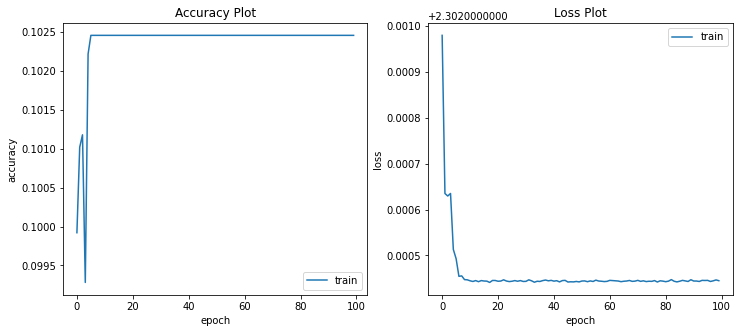

In [23]:
# plotting the loss and accuracy of the model.
plt.figure(figsize = (12, 5))

# plotting the accuracy vs epochs 
plt.subplot(1,2,1)
plt.plot(random_hist.history['accuracy'])
plt.title("Accuracy Plot")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'])

# plotting the loss vs epochs 
plt.subplot(1,2,2)
plt.plot(random_hist.history['loss'])
plt.title("Loss Plot")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])

plt.show()

In [24]:
# Evaluating the performance of the pre-trained model on the current dataset
random_model_score = random_model.evaluate(X_test, y_test)
print("Testing loss : ", random_model_score[0])
print("Testing accuracy : ", random_model_score[1])

313/313 [==============================] - 1s 2ms/step - loss: 2.3027 - accuracy: 0.1006
Testing loss :  2.3026504516601562
Testing accuracy :  0.1005999967455864


# Conclusion

### Visually comparing training accuray and loss of both the models

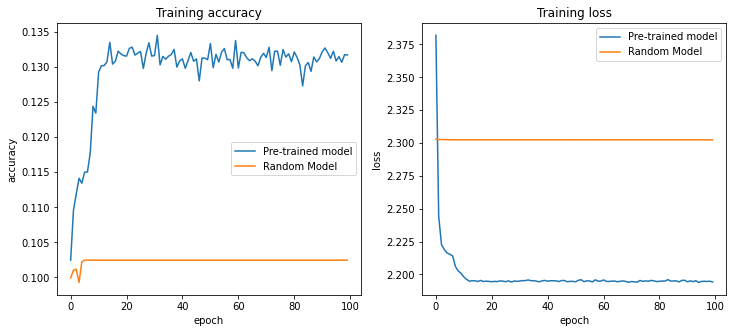

In [25]:
plt.figure(figsize = (12, 5))

# plotting the training accuracy of pre-trained and randomly initialised model
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(random_hist.history['accuracy'])

plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(["Pre-trained model", "Random Model"])
plt.title("Training accuracy")

# plotting the training loss of pre-trained and randomly initialised model
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(random_hist.history['loss'])

plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(["Pre-trained model", "Random Model"])
plt.title("Training loss")


plt.show()

### Comparing the testing accuracy and loss of both the models

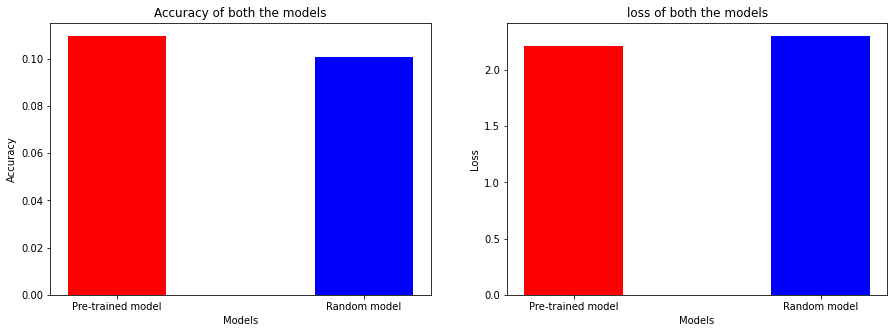

In [26]:
plt.figure(figsize = (15, 5))

# plotting the testing accuracy of pre-trained and randomly initialised model
plt.subplot(1,2,1)
X_acc = ["Pre-trained model", "Random model"]
y_acc = [score[1],random_model_score[1]]
plt.bar(X_acc, y_acc, color=['red','blue'], width = 0.4)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of both the models")


# plotting the testing loss of pre-trained and randomly initialised model
plt.subplot(1,2,2)
X_loss = ["Pre-trained model", "Random model"]
y_loss = [score[0],random_model_score[0]]
plt.bar(X_loss, y_loss, color=['red','blue'], width = 0.4)
plt.xlabel("Models")
plt.ylabel("Loss")
plt.title("loss of both the models")


plt.show()

### Training metrics of both the models

Model/metric | Accuracy | Loss |
-------------| --------- | ----------- |
Pre-trained model | 13.22%  | 2.19 |
Randomly initialised model | 10.26% | 2.30 |


### Testing metrics of both the models
Model/metric | Accuracy | Loss |
-------------| --------- | ----------- |
Pre-trained model | 11% | 2.21 |
Randomly initialised model | 10.29% | 2.30 |

Dataset:
* The images in each folder is wrongly organised in the respective folder. 
* Additionally each folder has images of all the other digits rather than the correct one. for e.g, folder 0 has images of all the digits from 1 to 9 and does not have any images of 0.
* There are almost 6k images in each folder. There are a total of 60k wrongly tagged images. This is a large dataset and sufficient enough to hinder the performance of the neural network.
* Since the image size is similar to part 2, we can completely utilize the pre-trained model and achieve the best possible performance.


Pre-trained model:
* The pre-trained model has been initialised with the parameters which are appropriate to predict the handwritten digits accurately. 
* These parameters help the model to accurately predict the few images which are correctly mapped to the right label. Due to these parameters, we can get higher accuracy and lower loss in comparison to the randomly initialised model.
* The higher accuracy can also be attributed to some of the shared features amongst the digits. For eg. 1 and 7 have a straight edge, 8 and 9 and 0 have similar curved features on the top half. Therefore, whenever we encounter a shared feature we have a slightly higher chance of predicting the class correctly.
* The higher accuracy of pre-trained is predominantly because of the pre-trained parameters and somewhat due to the shared features.

Randomly initialised model:
* The randomly initialised model is not able to perform accurately as it is not able to extract features that are mapped with the correct label. Due to this the randomly initialised model's accuracy and loss converge quickly. (within ~5 epochs).
* Due to this, the model performs badly and has an accuracy almost equal to the random guess probability of 0.1 (1/10). 